In [5]:
import numpy as np
from matplotlib import pyplot as plt
import json, os
from skimage.measure import label, regionprops

In [6]:
run = 1
Ks = np.array([1, 3, 5])
Ds = ([0.1, 0.3, 1, 2, 3, 5, 8, 10], [0.1, 0.3, 1, 2, 3, 5, 8, 10, 20, 30], [0.1, 0.3, 1, 2, 3, 5, 8, 10, 20, 30])
betas = np.array([[0.5, 0.7, 1.2], [1.0, 1.5, 2.0], [2, 3, 3.9], [3.2, 4.6, 6.1], [5, 7, 9], [8, 11.5, 15], [11, 15.5, 20], [15, 20, 25], [0, 35, 50], [0, 60, 80]])
alpha = 0.1
chi = 0.0
gamma = 5.0

ddir = 'data' #'/new_drho_data'#
model = '/model_tanh_implicit/vary_D' # '/model_hill'#

pdir = '../../'+ddir+model+'/K_{:d}/alpha_{:1.1f}_beta_{:1.1f}_chi_{:1.1f}_gamma_{:1.1f}/D_{:.1f}/run_{:d}/'.format(Ks[1], alpha, betas[0,1], chi, gamma, Ds[0][0], run)

datadir = pdir+'data/'

with open(pdir+'parameters.json') as jsonFile:
    parameters = json.load(jsonFile)

T         = parameters["T"]        # final time
dt_dump   = parameters["dt_dump"]
n_steps   = int(parameters["n_steps"])  # number of time steps
n_dump = int(T/dt_dump); dn_dump = int(n_steps/n_dump)
K         = parameters["K"]        # elastic constant, sets diffusion lengthscale of S with Gamma0
mx        = np.int32(parameters["mx"])
my        = np.int32(parameters["my"])
mu        = np.float32(parameters["mu"])
dx        = np.float32(parameters["dx"])
dy        = np.float32(parameters["dy"])
tauc      = np.float32(parameters["tauc"])
#setup a meshgrid
tol = 0.001

x   = np.linspace(0+tol, mx*dx-tol, mx)
y   = np.linspace(0+tol, mx*dx-tol, my)
xv, yv  = np.meshgrid(x,y, indexing='ij')


times = np.arange(0, n_dump, 1)*dt_dump

print(n_dump, T, mx, dx, tauc)

10 100 100 1.0 100.0


In [7]:
di=0

nr, nc = (4,3)
fig, ax = plt.subplots(figsize=(5*nc,5*nr), nrows=nr, ncols=nc)
defect_loc = np.zeros((len(betas[di]), 4, 2))

for b, beta  in enumerate(betas[di]):
    n=9
    pdir = '../../'+ddir+model+'/alpha_{:1.1f}_beta_{:1.1f}_chi_{:1.1f}_gamma_{:1.1f}/D_{:.1f}/run_{:d}/'.format(alpha, beta, chi, gamma, Ds[di], run)
    Qxx = np.loadtxt(pdir+'data/Qxx.csv.{:d}'.format(n), delimiter=',')
    Qxy = np.loadtxt(pdir+'data/Qxy.csv.{:d}'.format(n), delimiter=',')
    S = 2*np.sqrt(Qxx**2+Qxy**2)

    mask = S<0.2
    l_mask = label(mask)
    regions = regionprops(l_mask)
    i=0
    for region in regions:
        minx, miny, maxx, maxy = region.bbox
        defect_loc[b, i] = np.array([(minx + maxx )/2,(miny + maxy)/2])
        i+=1
    
    p_factor = 3
    theta = np.arctan2(Qxy, Qxx)/2
    Snx    = np.cos(theta)
    Sny    = np.sin(theta)
    
    plot1 = [ax[b//nc, b%nc].pcolormesh(xv, yv, S, cmap='viridis', vmin=np.min(S), vmax=np.max(S)), ax[b//nc, b%nc].quiver(xv[::p_factor, ::p_factor], yv[::p_factor, ::p_factor], Snx[::p_factor, ::p_factor], Sny[::p_factor, ::p_factor], color='b', pivot='middle', headlength=0, headaxislength=0, scale=0.5, scale_units='xy')]
    ax[b//nc, b%nc].set_xticks([])
    ax[b//nc, b%nc].set_yticks([])
    fig.colorbar(plot1[0], ax=ax[b//nc, b%nc], shrink=0.75)
    ax[b//nc, b%nc].axis('equal')
    ax[b//nc, b%nc].axis('off')
    ax[b//nc, b%nc].set_title(r'$\beta$={:.1f}'.format(beta))
plt.show()

TypeError: unsupported format string passed to list.__format__

Text(0, 0.5, 'Distance between defects (units of $\\sqrt{K/a}$)')

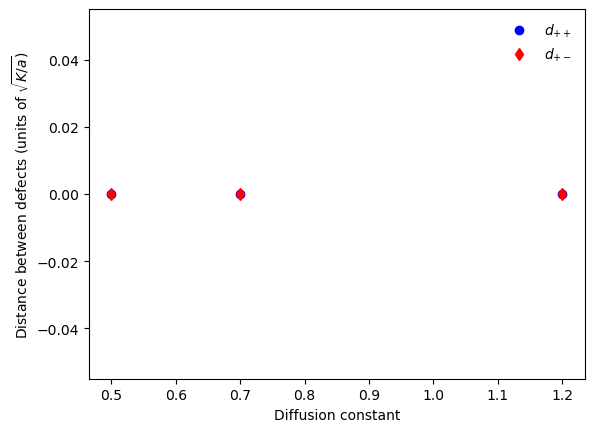

In [322]:
dpp = (defect_loc[:, 2, 1] - defect_loc[:,1, 1])*(np.sum(np.where(defect_loc[:,:,1]==0, 0, 1), axis=1)-3)
dpm_1 = defect_loc[:, 1, 1] - defect_loc[:, 0, 1]
dpm_2 = defect_loc[:, 3, 1] - defect_loc[:, 2, 1]
dmm = defect_loc[:, 3, 1] - defect_loc[:, 0, 1]

plt.plot(betas[di], dpp/2, 'bo', label=r'$d_{++}$')
plt.plot(betas[di], dpm_1/2, 'rd', label=r'$d_{+-}$')
#plt.plot(Ds, dmm/2, 'gp', label=r'$d_{--}$')
plt.legend(frameon=False)
plt.xlabel('Diffusion constant')
plt.ylabel(r'Distance between defects (units of $\sqrt{K/a}$)')

In [8]:
nr, nc = (3,3)
fig, ax = plt.subplots(figsize=(5*nc,5*nr), nrows=nr, ncols=nc)
defect_loc = np.zeros((len(Ds[1]), 4, 2))

for di, D  in enumerate(Ds[1]):
    n=9
    pdir = '../../'+ddir+model+'/K_{:d}/alpha_{:1.1f}_beta_{:1.1f}_chi_{:1.1f}_gamma_{:1.1f}/D_{:.1f}/run_{:d}/'.format(Ks[1], alpha, betas[di, 1], chi, gamma, D, run)
    Qxx = np.loadtxt(pdir+'data/Qxx.csv.{:d}'.format(n), delimiter=',')
    Qxy = np.loadtxt(pdir+'data/Qxy.csv.{:d}'.format(n), delimiter=',')
    S = 2*np.sqrt(Qxx**2+Qxy**2)

    mask = S<0.5
    l_mask = label(mask)
    regions = regionprops(l_mask)
    i=0
    print(len(regions))
    for region in regions:
        minx, miny, maxx, maxy = region.bbox
        defect_loc[di, i] = np.array([(minx + maxx )/2,(miny + maxy)/2])
        i+=1
    
    p_factor = 3
    theta = np.arctan2(Qxy, Qxx)/2
    Snx    = np.cos(theta)
    Sny    = np.sin(theta)
    
    plot1 = [ax[di//nc, di%nc].pcolormesh(xv, yv, S, cmap='viridis', vmin=np.min(S), vmax=np.max(S)), ax[di//nc, di%nc].quiver(xv[::p_factor, ::p_factor], yv[::p_factor, ::p_factor], Snx[::p_factor, ::p_factor], Sny[::p_factor, ::p_factor], color='b', pivot='middle', headlength=0, headaxislength=0, scale=0.5, scale_units='xy')]
    ax[di//nc, di%nc].set_xticks([])
    ax[di//nc, di%nc].set_yticks([])
    fig.colorbar(plot1[0], ax=ax[di//nc, di%nc], shrink=0.75)
    ax[di//nc, di%nc].axis('equal')
    ax[di//nc, di%nc].axis('off')
    ax[di//nc, di%nc].set_title(r'$D={:.1f}~,~\beta$={:.1f}'.format(D, betas[di,0]))

dpp = (defect_loc[:, 2, 1] - defect_loc[:,1, 1])*(np.sum(np.where(defect_loc[:,:,1]==0, 0, 1), axis=1)-3)
dpm_1 = defect_loc[:, 1, 1] - defect_loc[:, 0, 1]
dpm_2 = defect_loc[:, 3, 1] - defect_loc[:, 2, 1]
dmm = defect_loc[:, 3, 1] - defect_loc[:, 0, 1]

plt.plot(Ds, dpm_1/2 * dx, 'rd', label=r'$d_{+-}$')
plt.plot(Ds[:4],  28 + 4*np.log(Ds[:4]), color='k', linestyle='dotted')
#plt.plot(Ds, dmm/2, 'gp', label=r'$d_{--}$')
#plt.legend(frameon=False)
plt.xlabel('Diffusion constant')
plt.ylabel(r'$d_{+-}$ (units of $\sqrt{K/a}$)')
plt.xscale('log')


plt.show()

3
3
3
3
3
3
4
4
4
4


IndexError: index 3 is out of bounds for axis 0 with size 3

In [9]:
defect_loc = np.zeros((len(Ks),len(Ds[1]), 4, 2))

for ik, K in enumerate(Ks):
    for di, D  in enumerate(Ds[ik]):
        n=9
        if K==1:
            pdir = '../../'+ddir+model+'/alpha_{:1.1f}_beta_{:1.1f}_chi_{:1.1f}_gamma_{:1.1f}/D_{:.1f}/run_{:d}/'.format( alpha, betas[di, 0], chi, gamma, D, run)
        else:
            pdir = '../../'+ddir+model+'/K_{:d}/alpha_{:1.1f}_beta_{:1.1f}_chi_{:1.1f}_gamma_{:1.1f}/D_{:.1f}/run_{:d}/'.format(Ks[ik], alpha, betas[di, ik], chi, gamma, D, run)
        Qxx = np.loadtxt(pdir+'data/Qxx.csv.{:d}'.format(n), delimiter=',')
        Qxy = np.loadtxt(pdir+'data/Qxy.csv.{:d}'.format(n), delimiter=',')
        S = 2*np.sqrt(Qxx**2+Qxy**2)
    
        mask = S<0.5
        l_mask = label(mask)
        regions = regionprops(l_mask)
        i=0
        for region in regions:
            minx, miny, maxx, maxy = region.bbox
            defect_loc[ik, di, i] = np.array([(minx + maxx )/2,(miny + maxy)/2])
            i+=1

#dpp = (defect_loc[:,:, 2, 1] - defect_loc[:,:, 1, 1])*(np.sum(np.where(defect_loc[:,:,:,1]==0, 0, 1), axis=1)-3)
dpm_1 = defect_loc[:,:, 1, 1] - defect_loc[:,:, 0, 1]
dpm_2 = defect_loc[:,:, 3, 1] - defect_loc[:,:, 2, 1]
dmm = defect_loc[:,:, 3, 1] - defect_loc[:,:, 0, 1]

Text(0.5, 0, '$\\beta^2/K$')

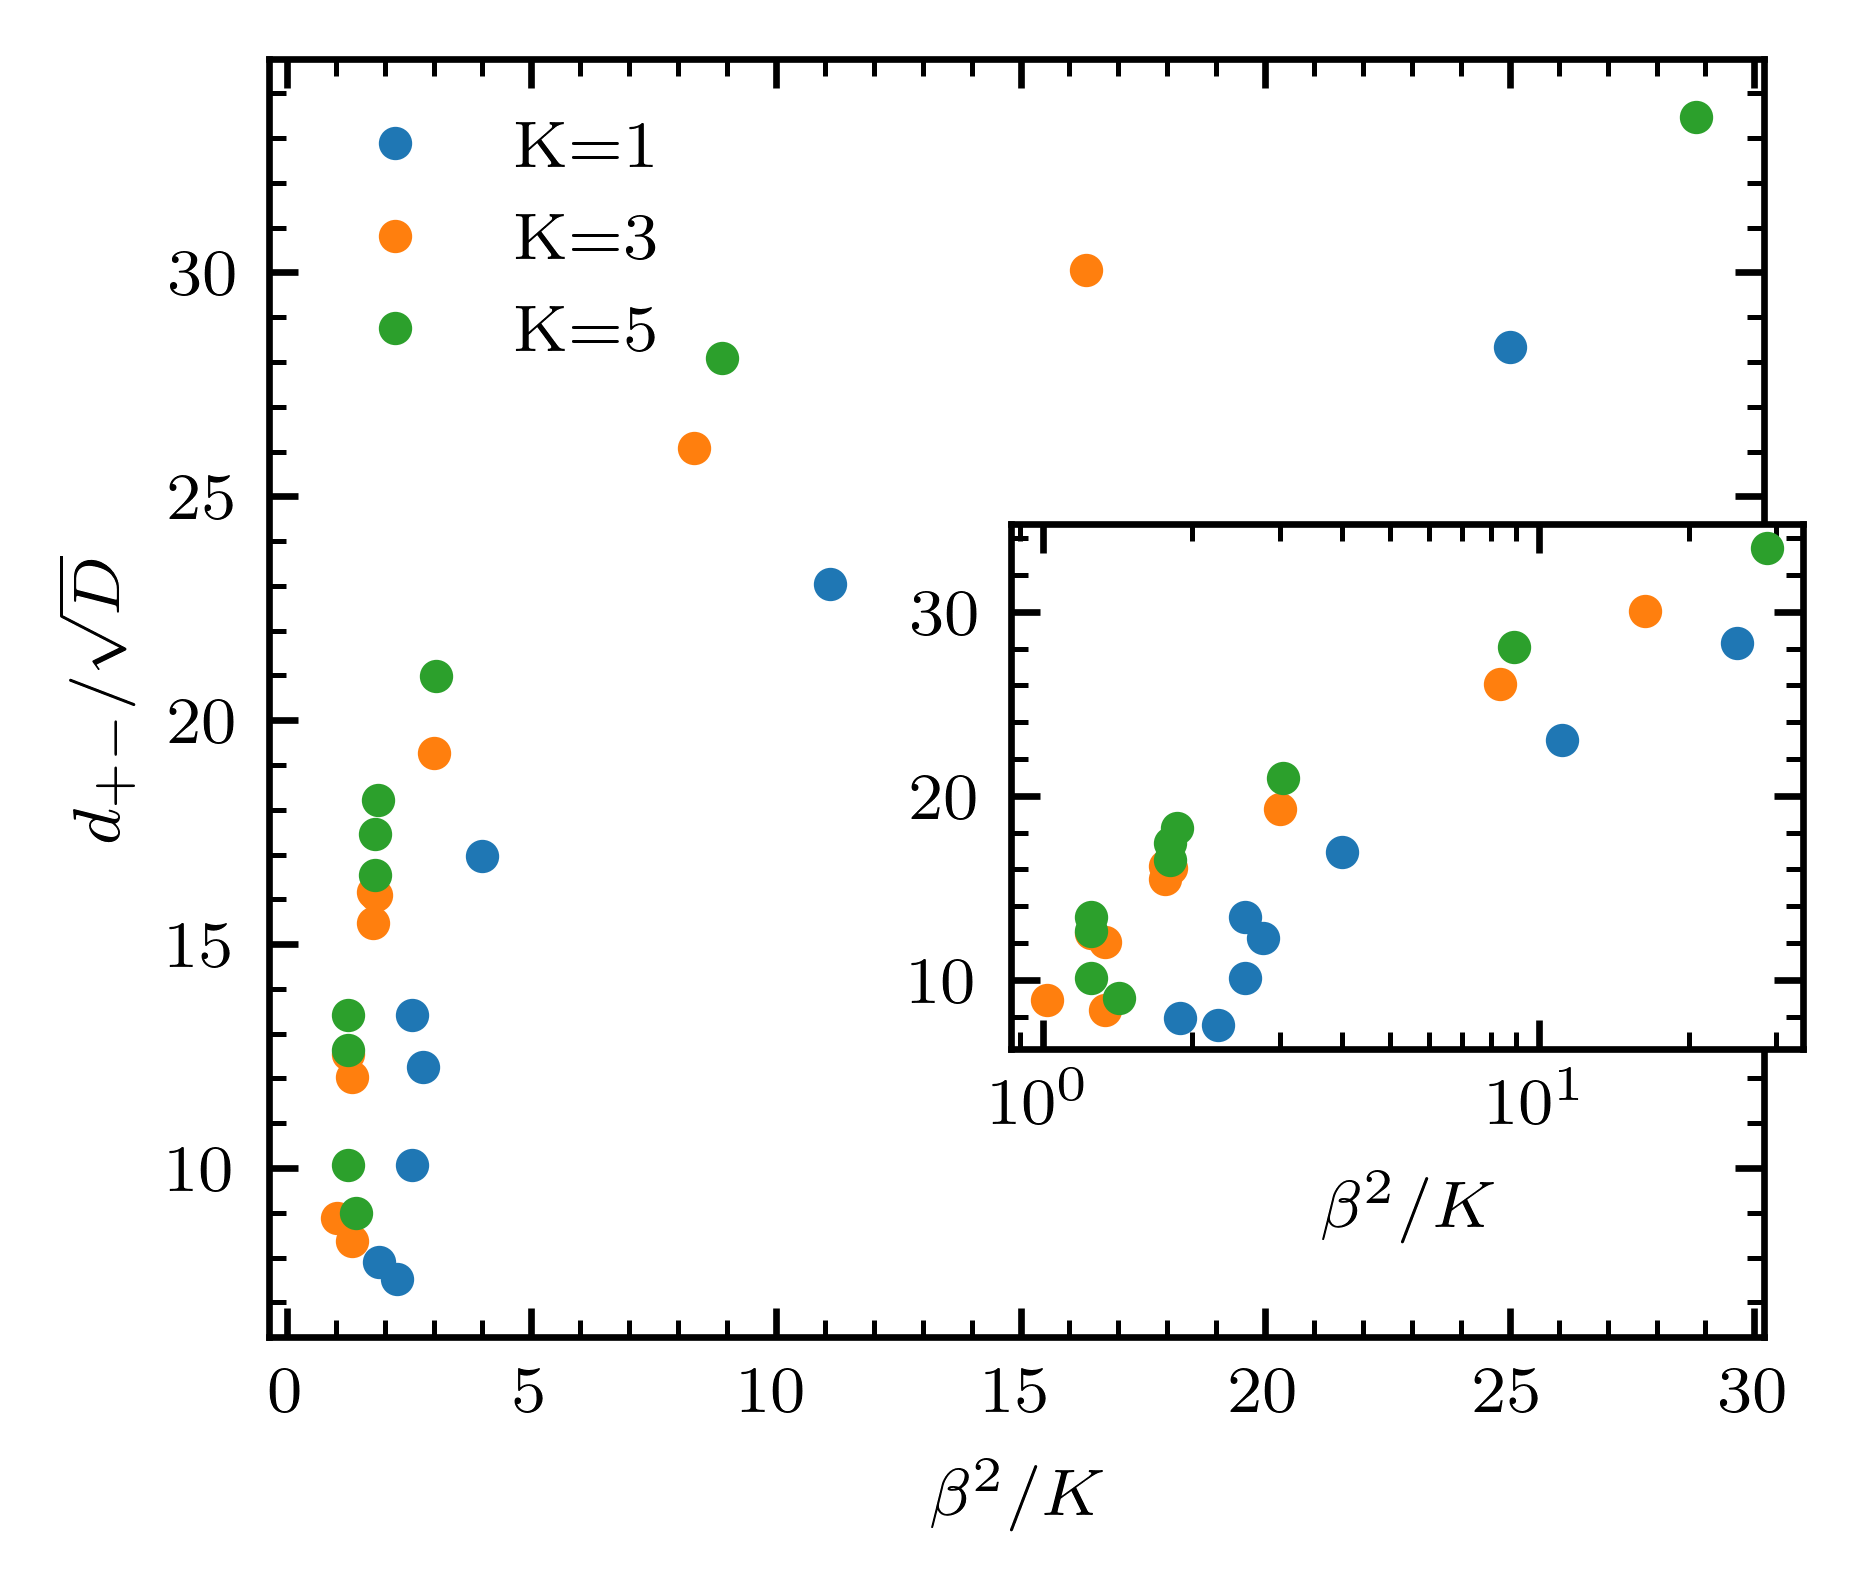

In [10]:
fig, ax = plt.subplots()

#dpp = (defect_loc[:, 2, 1] - defect_loc[:,1, 1])*(np.sum(np.where(defect_loc[:,:,1]==0, 0, 1), axis=1)-3)
dpm_1 = defect_loc[:,:, 1, 1] - defect_loc[:,:, 0, 1]
dpm_2 = defect_loc[:,:, 3, 1] - defect_loc[:,:, 2, 1]

ax_sub = fig.add_axes([0.5, 0.32, 0.40, 0.35])

for ik, K in enumerate(Ks):
    if K==1:
        dx=0.5
        ax.plot(betas[:-2,ik]**2/(K*np.array(Ds[ik])**2), dpm_1[ik,:-2]/2 * dx /np.sqrt(Ds[ik])+2*np.log(dpm_1[ik,:-2]/2 * dx /np.sqrt(Ds[ik])), 'o', label='K={:d}'.format(K))
        ax_sub.plot(betas[:-2,ik]**2/(K*np.array(Ds[ik])**2), dpm_1[ik,:-2]/2 * dx/np.sqrt(Ds[ik])+2*np.log(dpm_1[ik,:-2]/2 * dx /np.sqrt(Ds[ik])), 'o')
    else:
        dx=1
        ax.plot(betas[:,ik]**2/(K*np.array(Ds[ik])**2), dpm_1[ik]/2 * dx/np.sqrt(Ds[ik])+2*np.log(dpm_1[ik,:]/2 * dx /np.sqrt(Ds[ik])), 'o', label='K={:d}'.format(K))
        ax_sub.plot(betas[:,ik]**2/(K*np.array(Ds[ik])**2), dpm_1[ik]/2 * dx/np.sqrt(Ds[ik])+2*np.log(dpm_1[ik,:]/2 * dx /np.sqrt(Ds[ik])), 'o')

ax.set_xlabel(r'$\beta^2/K$')
ax.set_ylabel(r'$d_{+-}/\sqrt{D}$ ')
#plt.xscale('log')
ax.legend(frameon=False)

#ax_sub.plot(Ds[1]/Ks[1],  8 + 1.5*np.log(Ds[1]/Ks[1]), color='k', linestyle='dotted')
#ax_sub.plot(Ds[1]/Ks[1],  14 + 2*np.log(Ds[1]/Ks[1]), color='r', linestyle='dotted')

#ax_sub.plot(betas[:,1]**2/Ks[1],  np.log(betas[:,1]**2/Ks[1]), color='r', linestyle='dotted')

ax_sub.set_xscale('log')
ax_sub.set_xlabel(r'$\beta^2/K$')


Text(0, 0.5, 'Critical morphogen production rate, $\\beta_\\mathrm{crit}$')

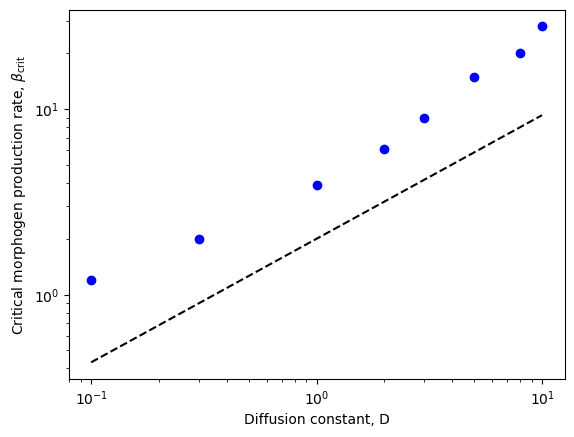

In [208]:
plt.loglog(Ds, betas[:,1], 'bo')
plt.loglog(Ds, 2*Ds**(2/3), 'k', linestyle='dashed')
plt.xlabel('Diffusion constant, D')
plt.ylabel(r'Critical morphogen production rate, $\beta_\mathrm{crit}$')

Text(0.5, 0, '$\\dfrac{KD^2}{\\beta^2}$')

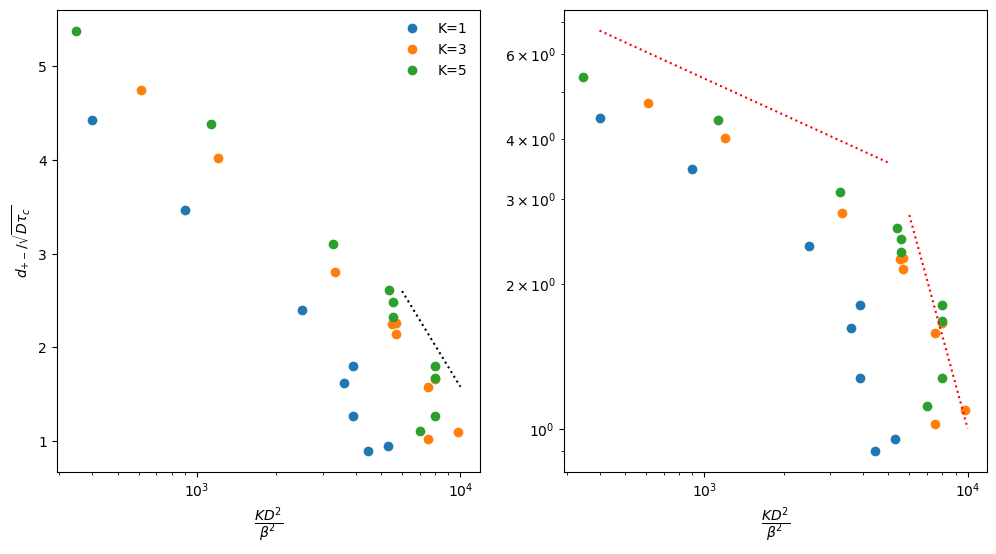

In [187]:
fig, axs = plt.subplots(figsize=(12, 6), ncols=2)

dpm_1 = defect_loc[:,:, 1, 1] - defect_loc[:,:, 0, 1]
dpm_2 = defect_loc[:,:, 3, 1] - defect_loc[:,:, 2, 1]

ax_sub = axs[1]
ax = axs[0]

for ik, K in enumerate(Ks):
    if K==1:
        dx=0.5
        d = dpm_1[ik,:-2] * dx
        lambd = np.sqrt(Ds[ik])*np.sqrt(tauc)
        b = betas[:-2,ik]
        xplot = K * lambd**4/b**2
        ax.plot(xplot, d/lambd, 'o', label='K={:d}'.format(K))
        ax_sub.plot(xplot, d/lambd, 'o')
    else:
        dx=1
        d = dpm_1[ik,:] * dx
        lambd = np.sqrt(Ds[ik])*np.sqrt(tauc)
        b = betas[:,ik]
        xplot = K * lambd**4/b**2
        ax.plot(xplot, d/lambd, 'o', label='K={:d}'.format(K))
        ax_sub.plot(xplot, d/lambd, 'o')
        
ax.set_xlabel(r'$\dfrac{KD^2}{\beta^2}$')
ax.set_ylabel(r'$d_{+-}/\sqrt{D\tau_c}$ ')
ax.set_xscale('log')
ax.legend(frameon=False)
ax.plot(np.arange(6e3, 1e4, 10),  20-2*np.log(np.arange(6e3, 1e4, 10)), color='k', linestyle='dotted')

ax_sub.plot(np.arange(4e2, 5e3, 10),   30/(np.arange(4e2, 5e3, 10))**0.25, color='r', linestyle='dotted')
ax_sub.plot(np.arange(6e3, 1e4, 10),   1e8/(np.arange(6e3, 1e4, 10))**2, color='r', linestyle='dotted')

ax_sub.set_xscale('log')
ax_sub.set_yscale('log')
ax_sub.set_xlabel(r'$\dfrac{KD^2}{\beta^2}$')


[[14.  19.  24.  25.5 28.  27.  25.5 27.   0.   0. ]
 [ 7.5 11.  14.  16.  19.5 24.  22.5 24.  23.  26.5]
 [ 8.5 12.  15.5 18.5 21.5 26.  25.5 26.5 27.  29. ]]


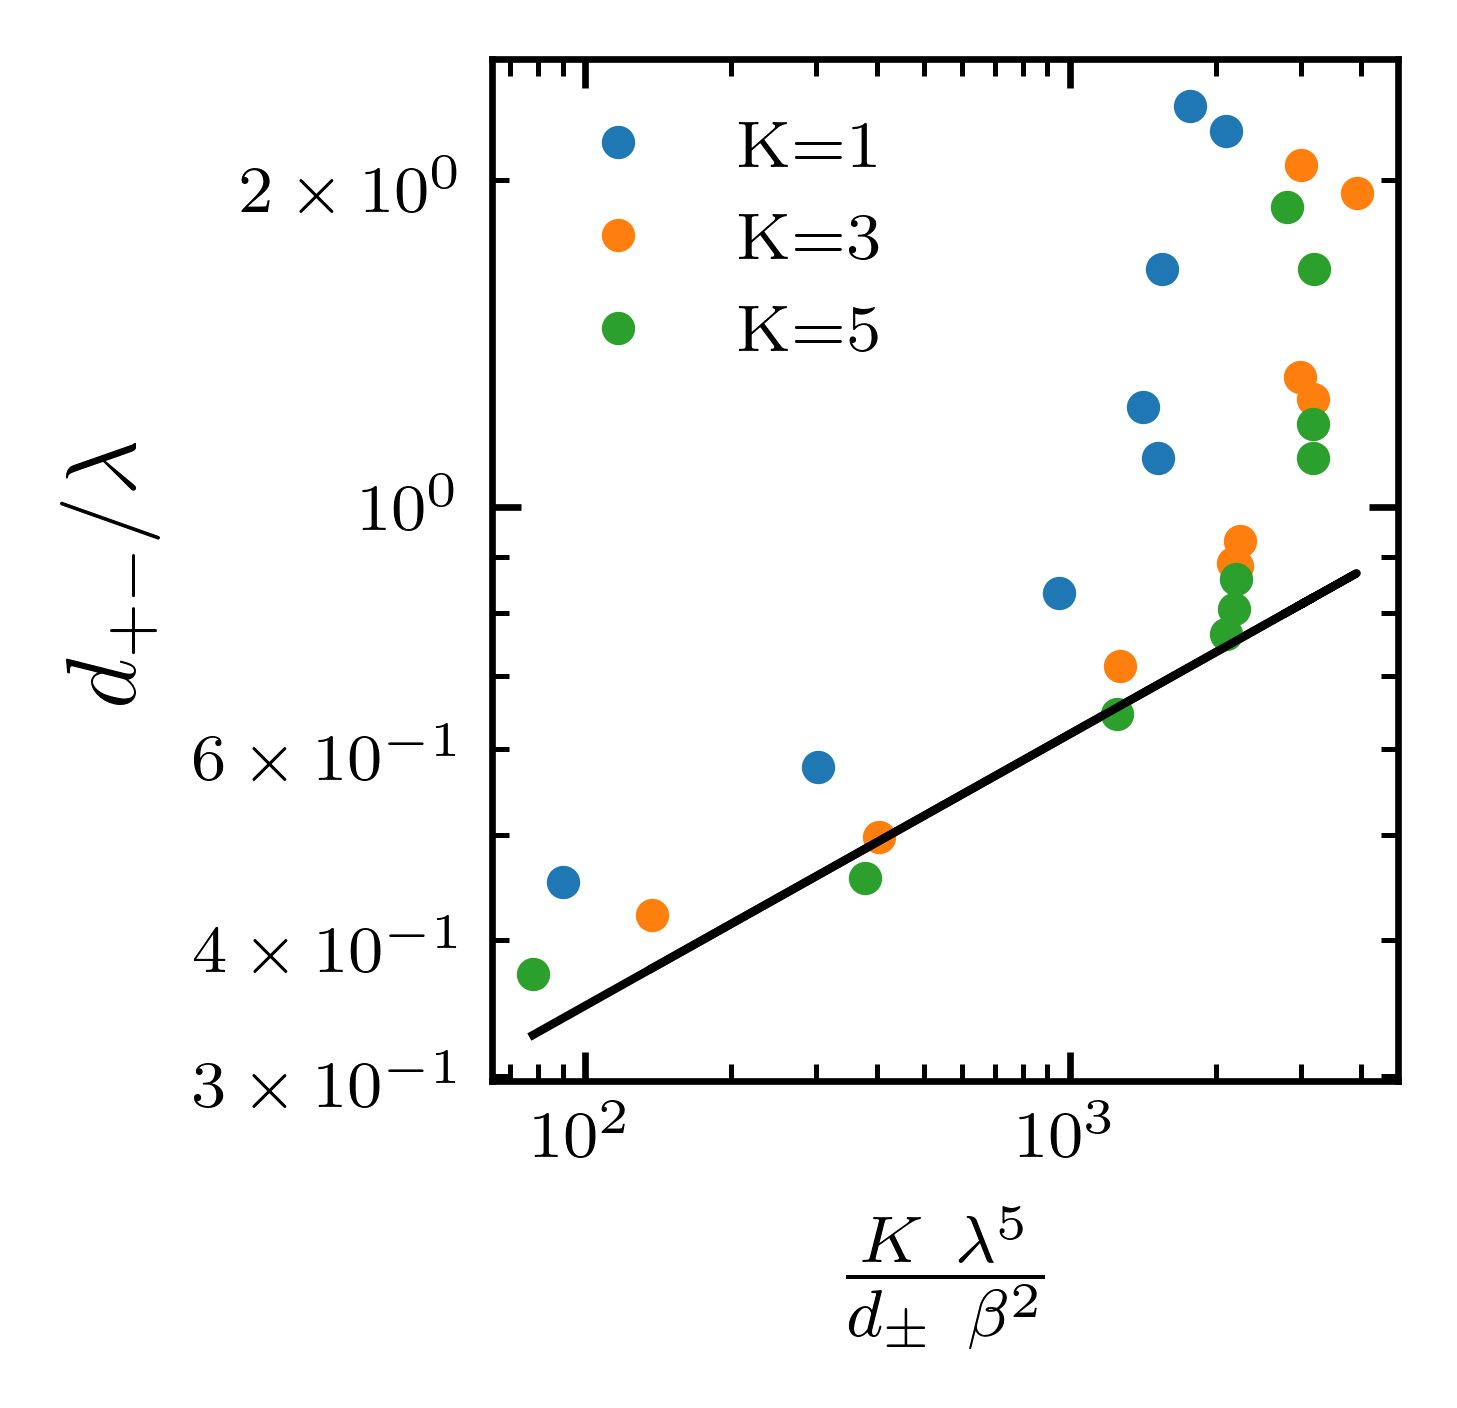

In [111]:
fig, axs = plt.subplots(figsize=(2, 2))

dpm_1 = defect_loc[:,:, 2, 1] - defect_loc[:,:, 0, 1]

print(dpm_1)

ax = axs

for ik, K in enumerate(Ks):
    if K==1:
        dx=0.5
        d = dpm_1[ik,:-2] * dx
        lambd = np.sqrt(Ds[ik])*np.sqrt(tauc)
        b = betas[:-2,ik]
        lambd_xi = np.sqrt(2.5/1)
        xplot = K *(lambd**2-lambd_xi**2)**2/(b**2 *lambd_xi**2)
        ax.plot(xplot, lambd/d, 'o', label='K={:d}'.format(K))
    else:
        dx=1
        d = dpm_1[ik,:] * dx
        lambd = np.sqrt(Ds[ik])*np.sqrt(tauc)
        b = betas[:,ik]
        xplot = K *((lambd**2)-lambd_xi**2)**2/(b**2 *lambd_xi**2)
        ax.plot(xplot, lambd/d, 'o', label='K={:d}'.format(K))
        ax.plot(xplot, 0.11*xplot**(1/4), color='k')
        
ax.set_xlabel(r'$\frac{{K~\lambda^5}}{{d_{\pm}~\beta^2}}$', size=12)
ax.set_ylabel(r'$d_{{+-}}/\lambda$ ', size=12)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(frameon=False)

#ax.plot(np.arange(1e2, 1e4, 10),  11-np.log(np.arange(1e2, 1e4, 10)), color='k', linestyle='dotted')
#ax.plot(np.arange(5e5, 1e7, 10),  1e2/(np.arange(5e5, 1e7, 10))**(1/4), color='k', linestyle='dotted')

#plt.savefig('d_pm_scaling.svg', bbox_inches='tight')
#plt.savefig('d_pm_scaling.png', bbox_inches='tight')

[[14.  19.  24.  25.5 28.  27.  25.5 27.   0.   0. ]
 [ 7.5 11.  14.  16.  19.5 24.  22.5 24.  23.  26.5]
 [ 8.5 12.  15.5 18.5 21.5 26.  25.5 26.5 27.  29. ]]


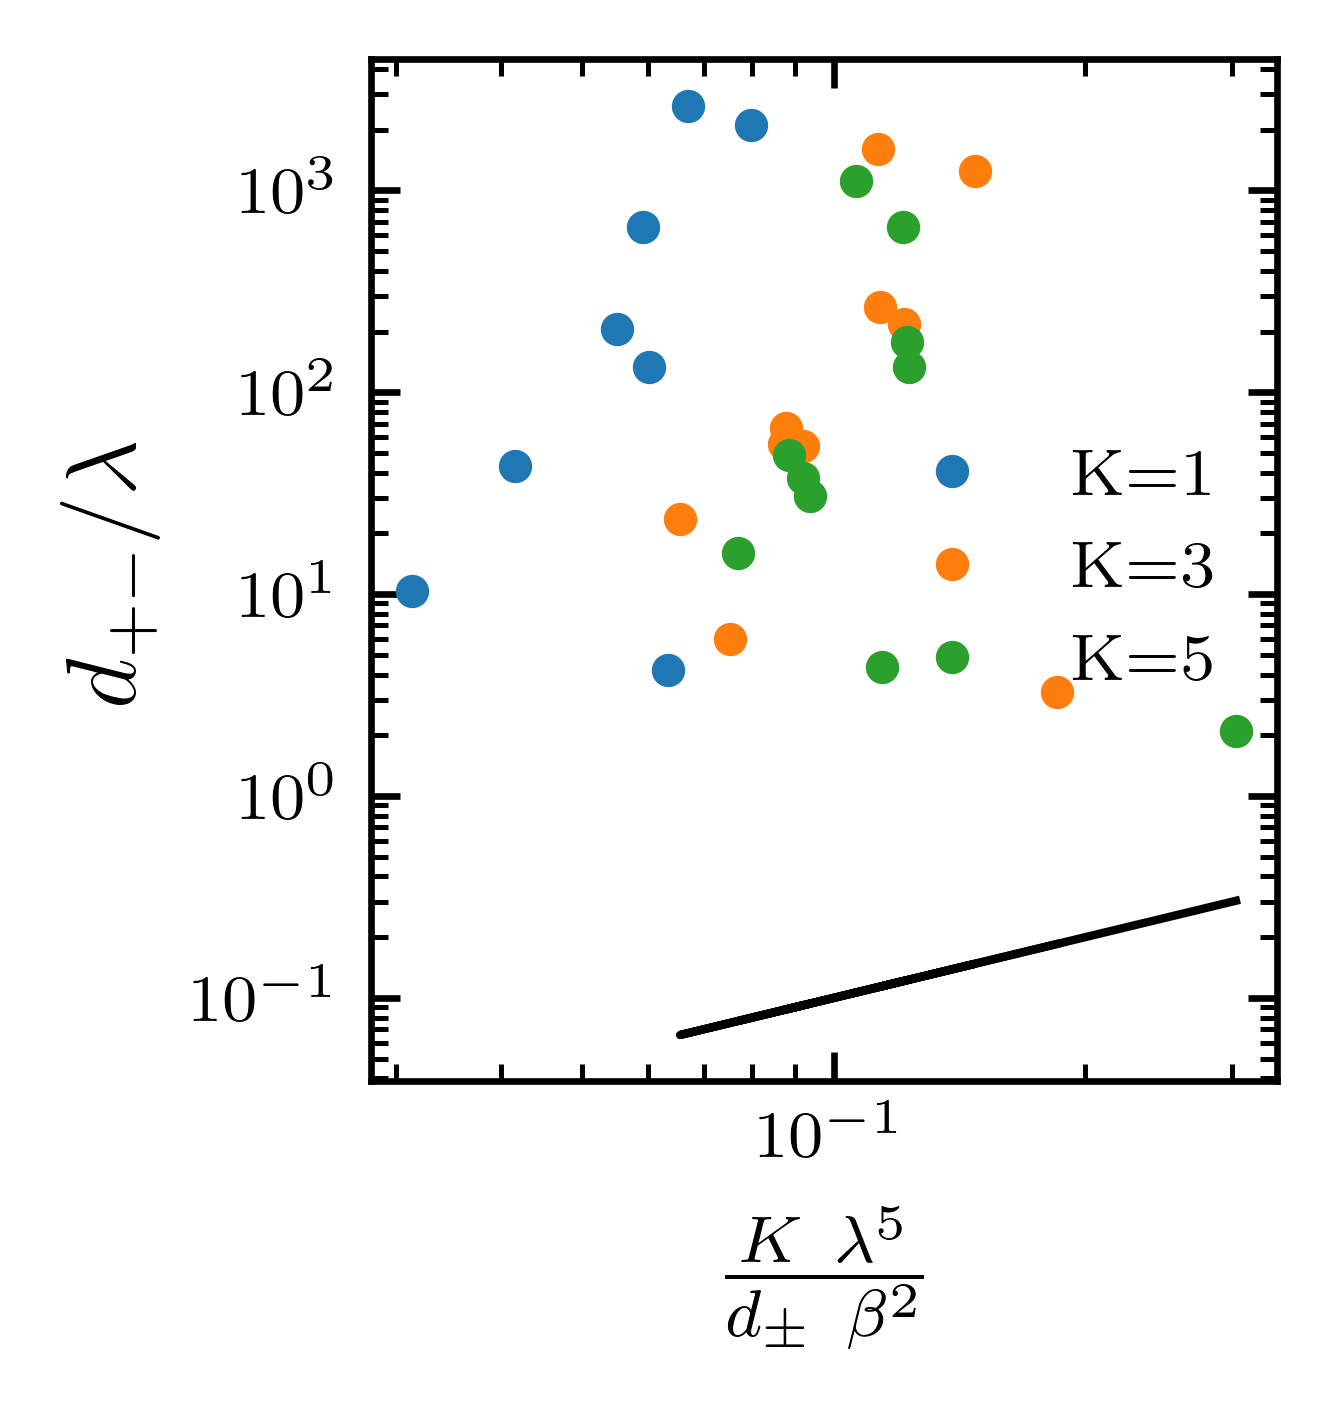

In [125]:
fig, axs = plt.subplots(figsize=(2, 2))

dpm_1 = defect_loc[:,:, 2, 1] - defect_loc[:,:, 0, 1]

print(dpm_1)

ax = axs

for ik, K in enumerate(Ks):
    if K==1:
        dx=0.5
        d = dpm_1[ik,:-2] * dx
        lambd = np.sqrt(Ds[ik])*np.sqrt(tauc)
        b = betas[:-2,ik]
        ct=0.1
        M=2.5
        xi=1
        lambd_xi = np.sqrt(M/xi)
        epsilon_t = 0.5
        S_bar = alpha*b*tauc*(lambd_xi**2)/(M*epsilon_t*(lambd**2 - lambd_xi**2))
        gamma_net = gamma/(ct**2 + (S_bar/lambd)**2)
        xplot = 3*K /(gamma_net*S_bar**2)
        yplot = (d/lambd) * (87.4*(lambd/d)**5 + (2.36*np.exp(-d/lambd)))
        ax.plot(xplot, yplot, 'o', label='K={:d}'.format(K))
    else:
        dx=1
        d = dpm_1[ik,:] * dx
        lambd = np.sqrt(Ds[ik])*np.sqrt(tauc)
        b = betas[:,ik]
        S_bar = alpha*b*tauc*(lambd_xi**2)/(M*epsilon_t*(lambd**2 - lambd_xi**2))
        gamma_net = gamma/(ct**2 + (S_bar/lambd)**2)
        xplot = 3 * K /(gamma_net*S_bar**2)
        yplot = (d/lambd) * (87.4*(lambd/d)**5 + (2.36*np.exp(-d/lambd)))
        ax.plot(xplot, yplot, 'o', label='K={:d}'.format(K))
        ax.plot(xplot, xplot, color='k')
        
ax.set_xlabel(r'$\frac{{K~\lambda^5}}{{d_{\pm}~\beta^2}}$', size=12)
ax.set_ylabel(r'$d_{{+-}}/\lambda$ ', size=12)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(frameon=False)

#ax.plot(np.arange(1e2, 1e4, 10),  11-np.log(np.arange(1e2, 1e4, 10)), color='k', linestyle='dotted')
#ax.plot(np.arange(5e5, 1e7, 10),  1e2/(np.arange(5e5, 1e7, 10))**(1/4), color='k', linestyle='dotted')

#plt.savefig('d_pm_scaling.svg', bbox_inches='tight')
#plt.savefig('d_pm_scaling.png', bbox_inches='tight')